In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

with open('./data/CESM2_pacific_SST.pkl', 'rb') as file:
    data = pickle.load(file)
data.shape

(6000, 24749)

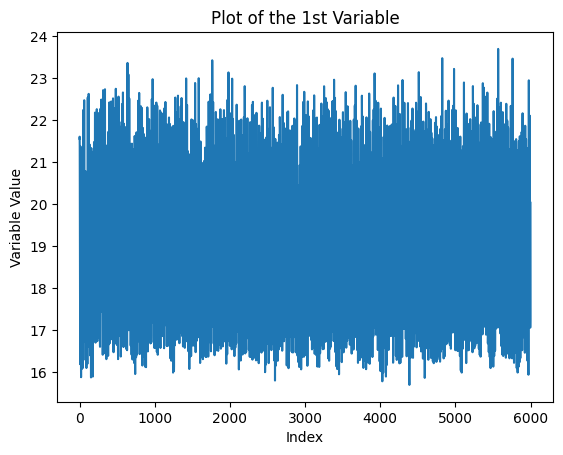

In [2]:
plt.plot(data[:, 100]) # Change 0 to other indexes if you want to plot a different variable
plt.xlabel('Index')
plt.ylabel('Variable Value')
plt.title('Plot of the 1st Variable')
plt.show()

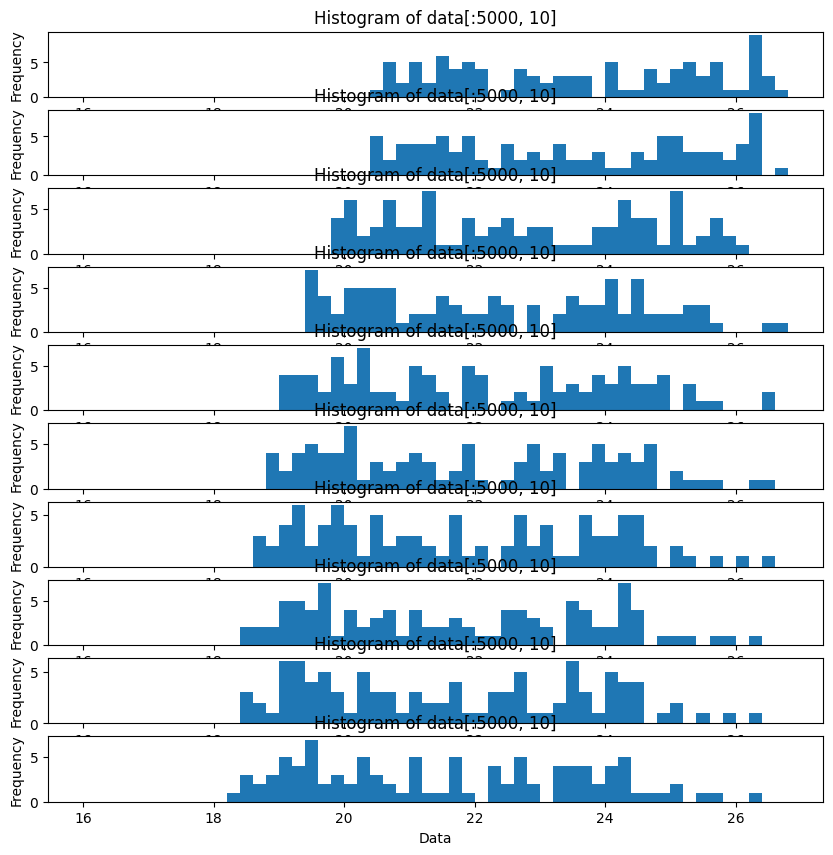

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 1, figsize=(10, 10))
bins = np.arange(16, 27, 0.2)
for i in range(10):
    axs[i].hist(data[:100, i], bins=bins)
    axs[i].set_title('Histogram of data[:5000, 10]')
    axs[i].set_xlabel('Data')
    axs[i].set_ylabel('Frequency')

In [4]:
predictions = np.load('./results/good3/epoch_20000/prediction.npy')
print(predictions[0])

[[ 0.     -0.0582  0.1105  0.      0.    ]
 [ 0.      0.      0.     -0.097   0.    ]
 [-0.0396  0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.     -0.1961  0.    ]]


In [5]:
def gaussian_log_likelihood(S, theta):
    n = theta.shape
    log_det_cov = np.log(np.linalg.det(theta))
    inv_cov_matrix = np.linalg.inv(S)
    diff = theta - L
    log_likelihood = -0.5 * N * np.log(2 * np.pi) - 0.5 * log_det_cov - 0.5 * np.sum(diff @ inv_cov_matrix * diff)
    
    return log_likelihood

In [6]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data = scaler.fit_transform(data)
print(data.shape, np.mean(data), np.var(data))

# Initialize Factor Analysis model with the number of components you want
n_components = 50  # You can adjust this value based on your needs
fa = FactorAnalysis(n_components=n_components)

# Fit the model
fa.fit(data)

# Transformed data
data_transformed = fa.transform(data)

# Factor loadings (shape will be (26500, n_components))
loadings = fa.components_


(6000, 24749) 1.1001094e-10 0.99999785


In [7]:
import torch
import torch.optim as optim
import numpy as np
from utils import check_tensor
from data import synthetic

theta = torch.randn(5, 5, requires_grad=True)
L = torch.randn(5, 5, requires_grad=True)
predictions = np.load('./results/good3/epoch_20000/prediction.npy')
S = check_tensor(predictions)



In [8]:


alpha = 0.01
tau = 0.01
optimizer = optim.SGD([theta, L], lr=1e-3)


def off_diag_l1_norm(matrix):
    off_diag = matrix - torch.diag_embed(torch.diag(matrix))
    return torch.sum(torch.abs(off_diag))

def nuclear_norm(matrix):
    return torch.sum(torch.svd(matrix).S)

for epoch in range(20000):
    optimizer.zero_grad()
    loss = torch.norm(S - theta + L) + alpha * off_diag_l1_norm(theta) + tau * nuclear_norm(L) + 0.1*torch.norm(theta, p=1) + 0.1*torch.norm(L, p=1)
    loss.backward()
    optimizer.step()
    # new = theta.clone()
    # new[torch.abs(theta) < 1e-6] = 0
    # theta = new
    
    if epoch % 10000 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')

print("S:", S)
print("theta:", theta)
print("L:", L)
print("theta - L:", theta - L)


Epoch 0, Loss 412.7169494628906
Epoch 10000, Loss 43.14106750488281
S: tensor([[[ 0.0000, -0.0582,  0.1105,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000, -0.0970,  0.0000],
         [-0.0396,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000, -0.1961,  0.0000]],

        [[ 0.0000, -0.0526,  0.1255,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000, -0.0785,  0.0000],
         [-0.0412,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.5880, -0.1431,  0.0000]],

        [[ 0.0000, -0.0256,  0.1245,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0572,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -1.0158,  0.0231,  0.0000]],

        ...,

        [[ 0.0000,  0.2474,  0.2529,  0.0000,  0.0000],
         [ 0.

In [9]:
from regain.covariance.latent_time_graphical_lasso_ import latent_time_graphical_lasso

latent_time_graphical_lasso(S)

AttributeError: 'Tensor' object has no attribute 'copy'

In [ ]:
import numpy as np
from regain.covariance import LatentTimeGraphicalLasso
from regain.datasets import make_dataset
from regain.utils import error_norm_time

np.random.seed(42)
data = make_dataset(n_dim_lat=1, n_dim_obs=3)
X = data.X
y = data.y
theta = data.thetas

mdl = LatentTimeGraphicalLasso(max_iter=5000).fit(X, y)
print("Error: %.2f" % error_norm_time(theta, mdl.precision_))

for i in range(5):
    print((mdl.precision_[i] + mdl.latent_[i]) @ X[i], X[i])

mdl.precision_[0], theta[0]

Error: 2.32
[-0.60162239  1.08048543 -0.81966126] [-1.52821108  1.63171995 -1.83863281]
[-0.67125173 -1.7127799  -0.64543504] [-0.58400943 -1.54055177 -0.55205265]
[0.71221339 2.60454781 1.43580241] [0.64591762 1.94965184 0.87776749]
[-1.40294091 -0.07910794  0.91840863] [-0.99420806  0.21251566  0.41438257]
[ 0.5215594   0.82719247 -0.98063654] [-0.32882728  1.48753809 -1.28224657]


(array([[ 1.2598282 ,  0.21123929, -0.53244871],
        [ 0.21123929,  1.04152677,  0.1610851 ],
        [-0.53244871,  0.1610851 ,  1.03131035]]),
 array([[3.63143449, 0.25      , 0.25      ],
        [0.25      , 1.01      , 0.25      ],
        [0.25      , 0.25      , 1.15509665]]))